# Python quantized model of a MLP neural network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [355]:
# **Quantization Function**
def quantize(value):
    bits = 8
    scale = 2 ** (bits - 1)
    saturated_value = np.clip(value >> (0), -scale, scale - 1).astype(np.int8)
    #print(f"value : {value}")
    #print(f"truncated_value : {saturated_value}")
    return saturated_value

In [392]:
# Average Pooling Function
def average_pooling(matrix, pool_size=2):
    # Flatten the matrix into a 1D array
    matrix = matrix.flatten()
    
    # Dimensions of the pooled output matrix
    new_h, new_w = 28 // pool_size, 28 // pool_size
    
    # Initialize the pooled matrix (1D array)
    pooled_matrix = np.zeros((new_h * new_w))#, dtype=int)
    
    # Perform the pooling operation
    for i in range(new_h):
        for j in range(new_w):
            # Calculate the starting index of the 2x2 block
            idx = i * pool_size * 28 + j * pool_size
            
            # Extract the 2x2 block using the correct indices
            block = [matrix[idx], matrix[idx + 1], matrix[idx + 28], matrix[idx + 29]]
            
            # Calculate the average (integer division)
            pooled_matrix[i * new_w + j] = np.sum(block) // 4  # Use // for integer division
    
    # Reshape the pooled matrix back to 14x14
    pooled_matrix_2d = pooled_matrix.reshape((new_h, new_w))
    
    return pooled_matrix_2d

In [469]:
# **Sigmoid Activation (LUT-based approximation for [-128, 127] -> [0, 127])**
def lut_sigmoid(input_x):
    #x = np.clip(input_x, -127, 127)  # Clip input to the range of the LUT
    return np.floor((1 / (1 + np.exp(-input_x / 30)) * 127)).astype(np.int8)

4


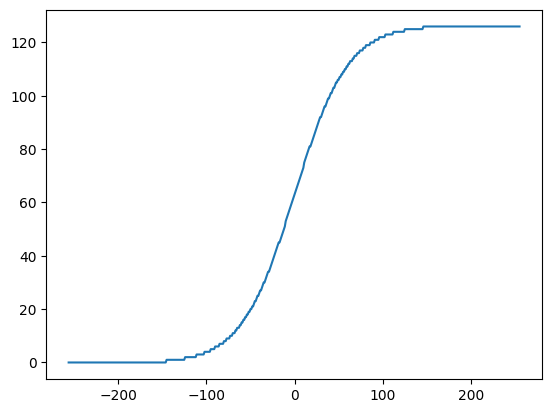

In [470]:
x = linear_array = np.arange(-256, 256)
plt.plot(x, lut_sigmoid(x))
print(lut_sigmoid(-100))

In [553]:
# **Forward Pass for a Single Layer**
def layer_forward(inputs, weights, biases):
    # Multiply-Accumulate: weights * inputs + biases
    mac = np.dot(inputs.astype(np.int64), weights.T.astype(np.int64)).astype(np.int32) 
    print(f'type: {type(mac)}')
    print(f'mac: {mac}, bias: {biases}')
    mac = mac + (biases).astype(np.int32)
    print(f'neuron output: {mac}')
    truncated = (mac >> 8).astype(np.int8)
    #truncated = np.array([quantize(x) for x in mac]).astype(np.int8)  # Quantize to 8 bits
    print(f'truncated: {truncated}')
    return lut_sigmoid(truncated).astype(np.int8)

In [536]:
# **Decision Function**
def decision(outputs):
    # Reverse the array to start from the last element
    reversed_outputs = np.flip(outputs, axis=0)
    # Find the index of the maximum value in the reversed array
    reversed_max_index = np.argmax(reversed_outputs, axis=0)
    # Adjust the index to reflect the position in the original array
    #original_max_index = outputs.shape[0] - 1 - reversed_max_index
    #print(reversed_max_index)
    
    #return original_max_index
    return reversed_max_index

In [468]:
weights_HL = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, 0, 0, -1, -1, 2, 0, 1, -1, 0, 1, 0, 0, -1, -1, 2, 0, 1, 
0, 0, 2, 0, 2, -1, 1, -1, -2, 0, 5, -1, 1, -1, -1, -1, -6, 1, 2, 1, -4, -1, 0, -1, -2, -2, -1, 4, 0, 5, 2, 3, 5, -1, 4, -3, 7, -1, -3, 1, 6, 0, 
0, 0, -2, -1, -7, 0, 3, 1, -4, -2, -1, 0, -3, -1, -2],
        [5, 0, 7, 3, 4, 5, 0, 4, -3, 9, 0, -2, 1, 4, 0, 0, 0, -1, 1, -4, -1, 3, 0, -2, -1, -1, -1, -1, 0, -2, 3, 1, 3, 1, 3, 2, 0, 2, -3, 6, -1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 1, 1, 1, -1, -1, 0, -1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, -1, 2, 0, -1, 0, 3, -2, 1, 3, 3, -4, -2, 4, -1, 0, 1, -2, 
2, 1, -2, -1, 0, 4, 1, -1, 0, -3, 2, 1, 1, -1, -1, 0, -4, 0, 5, -3, 2, 6, 6, -8, -5, 9, -3, 1, 3, -3, 6, 2, -3, -3, -1, 9, 2, -2, 2, -6, 5, 2, 2, -1, -3, -1, -10, -1, 4, -2, 2, 5, 6, -9, -5, 9, -3, 1, 3, -2, 7, 2, -2, -3, 0, 8, 1, -2, 1, -4, 5, 1, 3, -1, -4, 0, -9, -1, 1, -1, 1, 2, 3, -4, -2, 4, -1, 0, 1, -1, 4, 1, -1, -1, 0, 3, 1, -1, 1, -2, 2, 0, 1, 0, -2, 0, -4, 0, 0, 0, 0],
        [0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 2, -1, 2, 1, 3, -3, -1, 4, -1, 1, 0, 0, 4, 0, 0, -2, 0, 3, 0, -1, 0, 
0, 4, 0, 4, -1, -1, -1, -4, -3, 10, -2, 8, 3, 7, -12, -8, 13, -2, 4, -5, 0, 11, 1, -3, -9, 3, 12, 1, 3, 3, 1, 17, 0, 15, -3, 1, -4, -13, -4, 21, 0, 10, 6, 2, -9, -18, 8, 2, 4, -13, -4, 4, 0, -12, -14, 3, 16, -3],
        [14, 5, 7, 24, 3, 24, -5, 16, -4, -11, 6, 15, 1, 3, 3, -6, 9, -7, -3, 8, 2, -9, -7, -11, -4, -8, 0, -6, 10, 7, 9, 2, 8, 10, 5, 13, -7, 19, -9, -1, 14, -6, 3, -1, -10, -7, 18, 8, -5, 7, 7, -3, -1, -12, -8, 10, 19, -17, 5, 22, -3, 0, 5, -5, 0, 1, -8, 5, -16, 2, 7, -15, 3, 7, -15, 0, 6, 10, -2, -2, 13, -10, 18, 5, -7, 12, 15, -3, -7, 16, -3, 6, 12, 2, -7, 11, 4, -9, -14, 0, -2, -2, -14, 17, 1, 11, -22, -7, 0, -5, 8, 1, 22, 
24, -1, -10, 4, 4, -7, -10, 4, 9, 15, 3, -2, 19, 14, -15, 2, 2, -5, 9, -21, 17, 22, 23, -40, -29, 6, -10, -1, 22, 9, 29, 2, -28, 0, 1, 7, -19, 1, 16, 1, -1, 11, 12, 19, -18, 11, -3, -4, 12, -18, 14, 21, 23, -37, -27, 19, -7, -2, 19, 3, 29, 8, -21, -6, 0, 16, -9, 0, 9, -5, 7, 9, 14, 10, -17, 7, -15, 0, 7, -5, 0, 10, 14],
        [-20, -15, 21, -5, -1, 3, -1, 16, 8, -6, -6, -1, 13, 0, 0, 5, -7, 11, 2, 4, 0, -2, 5, -19, 1, 2, -1, 0, -1, 2, -4, -6, 6, 0, 3, -2, -1, 
2, 0, 1, 1, -5, 7, 2, 3, 3, -1, 5, -1, 1, -4, 2, -1, -7, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 1, -2, 2, -1, 1, 2, 0, -1, 0, 1, 0, 0, -1, 1, -1, 0, 0, -1, 0, 2, 1, -7, 7, -5, 11, 7, 9, -15, -6, 7, -2, 1, 4, -2, 14, 3, -2, -8, 3, 11, -5, -2, -1, 5, 10, 2, 16, -2, -7, 3, -6, -16, 19, 5, 22, 11, 10, -23, -27, 10, -5, 5, -7, -5, 18, 3, -13, -19, 11, 20, -6, 9, 10],
        [15, 31, 6, 40, 4, 2, -2, -10, -6, 25, 12, 13, 10, -12, 3, -29, -10, 3, -2, -14, -15, -13, -2, -28, -16, 3, 13, 0, 22, 10, 17, 23, 11, 40, 3, 28, -14, 5, 25, -2, 11, -7, -10, -30, 51, 17, -29, 17, -6, 2, -12, -43, -8, -4, 18, -21, -5, 38, 2, -6, 4, -21, 2, 4, -8, 15, -32, 25, 32, -42, 29, -12, -39, -18, 60, 36, -19, 10, 10, 0, 12, -28, -13, 38, 48, -22, -14, 68, -15, 12, 5, -25, -17, -10, -2, -8, -44, 16, 0, -49, 31, 9, 
-44, 7, 16, 31, -10, -8, 28, -20, 47, 24, -14, 49, 28, 17, -28, 32, -11, 37, 47, 7, -28, 34, 22, -29, -17, 9, -19, -26, 3, 29, -30, 8, -17, 16, 
-21, -7, 24, -11, 53, 46, -11, 21, 0, 27, -34, -15, 3, 26, 60, 7, -22, 55, 30, -34, 13, 25, -6, -3, -15, 22, 21, 11, -34, -33, -28, -9, -18, 48, 22, 26, 3, -43, 1, 11, -17, -28, 3, 30, 10, -29, 8, 18, 50, -24, 19, 36, 9, 15, -23, 15, 43, 23, -35, -48],
        [-1, -3, -35, 51, 9, 23, 22, -64, -5, 8, -3, -20, 3, 20, -14, -21, 24, 9, 45, -13, 13, 13, 13, 16, -14, 0, 18, 16, -22, -29, 31, 0, -14, 5, 7, 23, 22, -28, -17, 2, 11, 0, 10, 5, -12, 14, 6, 13, 10, 6, 0, -23, 5, 6, -5, 1, -5, 1, -5, -17, 13, 1, 10, -6, -6, 0, -3, 5, 5, -18, 23, 9, 8, 5, -3, 14, -1, 1, -14, 8, -9, -18, 0, 1, -2, 0, -1, -1, 0, -1, 0, 2, 2, -1, -1, -1, -1, 1, 2, -3, 3, 0, 1, 0, 1, 1, 0, 0, -3, 0, 0, -1, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -4, 1, 0, -1, 1, -1, -3, -1, -2, 4, -6, 8, -4, 4, 5, 0, 
-3, 0, 3, -2, -1, -3, 4, -3, -2, 3, -3, -2, 7, 3, -21, 14, -8, 22, 16, 16, -30, -16, 5, -3, -5, 18, -7, 28, 10, -7, -16, 7, 23, -12, -5, -4, 17, 13],
        [6, 34, -3, -21, 12, -2, -23, 21, 12, 29, 18, 4, -24, -47, -2, -13, -2, 4, -16, 12, 4, -29, -19, 9, 27, -1, 12, 16, 17, 33, 15, 51, 11, 
-7, -11, -1, -4, 14, 13, 9, 2, -33, 24, -32, -42, 6, -5, -5, -22, -42, -12, -35, -1, -13, 6, 8, 28, 11, 18, 1, 16, 26, 8, 26, -30, 30, 29, -18, 
21, -11, -17, -37, 79, 33, -62, 25, -3, 9, -11, -67, -15, 5, 35, -17, -20, 45, -1, 0, 0, -42, 7, -24, 3, 0, -48, 58, 24, -52, 47, -10, -36, -2, 
60, 41, -21, 1, 16, -2, 12, -33, -20, 49, 54, -2, -16, 70, -17, 36, -8, -18, -15, -37, 14, -26, -53, 20, -18, -68, 44, 1, -35, 30, -6, 20, -12, 
-25, 26, 12, 49, 33, -20, 56, 37, 19, -31, 14, -19, 58, 37, -13, -28, -20, 41, -56, 1, 10, -27, -36, 3, 22, -45, -14, 10, 59, -48, 1, 16, 8, 63, 36, -7, 43, -13, 23, -49, -13, -7, -25, 71, -23, -36, 41, 24, -57, 18, 49, -6, 1, -17, 5, -1, -35, 1, 30, -51, 21],
        [-47, 44, 31, 22, 35, -26, -42, 29, -45, -19, 9, -40, 30, -46, -29, 37, 24, -23, 39, 62, 12, 12, -9, -7, 45, 12, -36, -56, -12, -1, -63, 59, 11, 22, 40, -74, -11, 11, -14, -29, 15, 23, -15, -36, 11, -6, 48, 0, 35, 23, 25, 13, -12, 2, 19, 11, -13, -43, 22, -1, -21, 6, 16, 16, 21, 
-45, -3, -6, 2, 2, 21, 18, -16, 10, 11, 3, 25, 7, -16, -13, 10, 12, -12, 7, -5, -4, -1, -26, 11, 5, 15, -3, -14, -7, -7, 6, 11, -33, 39, 22, 11, 6, -5, 18, 4, 2, -21, 10, -26, -20, 1, 4, -5, 1, -1, -1, 1, -3, 0, 5, 3, -1, -2, -1, -2, 1, 3, -7, 6, 0, 3, 0, 3, 3, 1, 1, -6, 2, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, -1, 1, -1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, -1, -1, 0, -1, 0, 1, 0, -8, 3, -2, -2, 2, -2, -6, -4, -4, 8, -13, 17, -6, 9, 12, 1, -6, 0, 8, -1, -1, -6, 8, -6, -4, 4],
        [-8, -5, 14, 6, -22, 22, -21, 24, 29, 23, -41, -26, 7, -7, -17, 32, -10, 36, 23, -22, -21, 10, 29, -21, -8, -7, 15, 12, 9, 36, -2, -36, 
21, 1, -11, 17, -13, 27, 21, -3, -25, -52, -12, -16, -10, 19, -17, 2, 6, -45, -5, -11, 27, 0, 10, 6, 2, 11, 20, 31, 11, -24, -21, 9, 4, 12, -15, 17, 0, -33, 21, -37, -68, 26, 7, 18, -18, -45, -19, -29, 27, -38, 16, 0, 28, 9, 27, -24, 26, 7, 0, 7, -32, 56, 24, -25, 43, 0, -22, -48, 83, 18, -84, 18, 6, 4, -5, -79, -27, 5, 53, -20, -25, 56, 7, 32, -5, -43, 4, -24, 20, -24, -69, 73, -4, -73, 102, -3, -30, -21, 35, 20, -30, -45, 2, 14, 6, -35, -20, 31, 28, 23, -29, 99, -21, 61, -45, -23, -28, -33, 59, -93, -81, 17, -50, -68, 57, 11, -11, 13, -22, 20, -22, -42, 7, 61, 20, 15, -11, 42, -8, 34, -27, 27, -46, 11, -12, -41, -13, -35, 55, -112, -1, 12, -44, -19, 3, 16, -20, -31, 27, 81, -65, 22, -6, 36],
        [26, 6, 12, 39, -46, 33, -44, -8, -39, -80, 50, -50, -11, 14, 6, -59, 34, 62, -26, 11, -10, -14, -11, -61, 21, 61, -70, 63, -67, 40, 6, 
26, 63, -1, -77, 50, -52, -15, 0, -86, 58, -53, -42, 28, -21, -10, 75, 83, -3, -4, 19, -31, 7, -18, -23, -54, -27, 13, -74, 46, 2, 28, 51, -35, 
-19, 10, -19, -12, 29, 23, 4, -33, -31, -17, 17, 8, 54, 29, 37, 14, -15, 21, 15, -11, -2, -44, 0, -11, -31, 12, 20, 1, 21, -65, 3, -9, -8, 21, 32, 23, -27, 2, 1, 19, 42, -16, -60, 6, 14, 18, -16, 16, 2, -7, -1, -30, 3, 9, 8, 13, -20, -10, -4, -5, 11, -38, 44, 30, 12, 7, -6, 12, 9, 5, -18, 7, -41, -9, 2, 6, -8, 2, -1, -2, 1, -4, -1, 8, 2, 2, -4, -1, -1, -1, 4, -11, 9, 0, 5, -1, 5, 2, 1, 0, -9, 5, 0, 1, 0, 0, 0, -1, 0, -1, 0, 0, 0, 1, -2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, -1, -1, -1, -1, 0],
        [1, 0, -9, 5, -4, -5, 2, -2, -9, -5, -2, 14, -18, 23, -9, 14, 19, 2, -9, 0, 14, 2, -2, -7, 11, -6, -7, 0, -14, -7, 21, 4, -8, 34, -42, 21, 36, 23, -41, -18, 14, -4, -36, 30, -2, 44, 42, -43, -33, 22, 10, -34, -4, -21, 7, 8, 2, 34, 4, -36, 33, 4, 18, 16, -70, 28, 19, 7, -31, -19, 
3, 7, -10, 38, -16, 17, 13, -37, 17, -41, 27, -8, -7, -30, -16, -22, 20, 4, -13, -40, -14, 6, 24, 12, -52, 16, -13, -20, 12, -22, -40, 52, 14, 19, -19, -23, -18, -7, 48, -70, 23, -11, 24, -7, 25, -31, 9, -6, -36, 20, -16, 36, 38, 4, 58, -21, -8, -51, 61, -13, -25, 13, -34, 0, -25, -56, 10, -14, 8, -5, -17, 63, 17, 41, -36, -12, -32, -7, 7, 34, -57, 19, 37, -9, 54, -13, 42, -9, 34, 46, 32, -30, -48, 49, -43, -33, 45, -4, -36, 46, -10, 95, -68, -8, -110, -23, 3, -28, 36, -80, -60, -18, 1, 14, -3, 9, 71, 36, 13, 84, 34, -26, -17, 27, -32, -17],
        [30, 3, -64, 80, -29, -4, -96, -64, -78, -20, 57, -11, 32, -69, 13, -16, -21, 34, -2, 4, 41, 6, 49, 97, -19, 3, 1, -43, -21, -29, 6, 7, 
-79, 89, -55, -54, -64, -87, 4, 3, 58, 19, 10, 13, 49, 27, -34, 20, 6, -24, 1, -18, 26, 29, -42, 38, -22, -27, -26, 2, 15, 11, -48, 53, -31, -63, -1, -45, 55, 2, 8, 0, -24, 55, 94, 48, -24, -14, 38, -34, -23, -21, -3, -38, -26, 33, -53, 32, -20, 21, 45, 18, -2, 2, 8, 9, 22, 29, 29, -8, -38, -23, -19, 15, 53, 24, 46, 18, -12, 29, 16, -33, 15, -24, -18, -11, -45, 20, 13, -15, 30, -78, -12, 6, -25, 44, 27, 11, -38, -7, -8, 35, 49, 
-28, -88, 26, 18, 22, -21, 21, 7, -14, 3, -31, -8, 13, 0, 21, -22, -15, -5, -18, 7, -37, 37, 29, 16, 2, -6, 2, 12, 9, -15, 6, -45, 4, 3, 7, -12, 3, -3, -4, 2, -5, -2, 12, 4, 4, -5, -2, -3, 0, 7, -15, 12, 1, 7, -4, 7, 0, 1, 0, -13, 6, -1, 2],
        [0, 0, 0, -1, 0, 0, 0, 0, 0, 1, -1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, -1, -1, 0, 1, 0, -8, 4, 2, -11, -2, -2, -5, 0, 0, 18, -17, 22, -11, 16, 22, 10, -10, 2, 16, 10, -3, -5, 12, -3, -12, -8, -20, -4, 24, 2, -5, 34, -33, 15, 33, 12, -31, -13, 2, -3, -48, 26, 9, 43, 51, -51, -39, 43, -17, -30, 6, -18, 9, 0, -7, 33, 26, -32, 34, 17, 35, 3, -112, 43, 10, 9, -34, 8, 2, 40, -8, 85, -14, 39, 14, -12, 43, -83, 36, 6, -23, -65, -20, -70, 14, -14, -40, -72, -17, 14, 37, 23, -104, 18, -14, 12, -34, -43, 26, 71, -2, 38, -23, 45, -2, -5, 55, -107, 52, -22, 39, -26, 
25, -19, -12, -11, -70, 51, 12, -14, 65, 57, -28, -24, 28, 33, 4, -17, 98, 28, -21, -34, -38, 21, 33, -19, -9, -9, 29, -4, 22, -5, -43, 54, -1, 
-2, -36, 103, 12, -76, 67, 29, -37, -27, 49, 48, 47, 102, 107, 11, -5, -14, -55, -22, 46, 28],
        [-23, 26, 11, 21, -77, -80, -105, 18, 51, -45, -36, -18, 11, -72, 9, 31, -10, -12, 40, 21, 43, 95, 44, 11, 0, -23, -46, -29, 26, 25, -62, 70, -17, -9, -64, -72, -48, 19, 44, -6, -22, -10, 38, -31, -46, 21, 19, 12, 12, 15, 35, 61, -13, -15, 58, -73, -32, -37, -41, 41, -44, 69, -21, -58, -34, -32, 30, 47, 52, 24, -2, 28, 42, 3, -33, 7, 3, 4, 3, 6, 7, 5, -29, 12, 12, -13, -27, -6, -11, 19, -3, 23, 0, -46, -3, 0, 38, 9, 22, 
8, -10, 36, 44, 28, -23, -12, 37, -29, -18, -7, -5, -11, -3, 35, -45, 27, -21, 27, 52, 27, -8, 15, 8, 28, 3, 21, 29, 4, -32, -9, -22, 4, 40, 9, 
44, 21, 5, 8, 18, -20, 20, -13, 1, -12, -37, -14, 3, -18, 24, -69, -17, 23, -36, 28, 22, 11, -36, 10, -3, 22, 41, 2, -60, 9, 18, 22, -22, 22, 2, -21, 12, -20, -11, 16, 1, 8, -19, -20, -9, -20, 1, -29, 25, 23, 20, -7, -3, 0, 11, 13, -14, 9, -39, 8, 4, 8],
        [-14, 3, -5, -5, 2, -6, -3, 14, 6, 2, -5, -3, -4, 0, 8, -17, 14, 1, 9, -6, 8, -1, 0, 1, -16, 8, -1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, -12, -1, 13, -13, -7, -6, -1, 5, -1, 18, -12, 17, -11, 13, 19, 18, -11, 5, 13, 17, -3, -3, 12, 0, -15, -12, -20, -5, 23, 2, -20, 15, 8, 1, 20, 0, -18, -9, -13, -4, -43, 17, 15, 28, 46, -31, -40, 54, -28, -10, 7, 3, 14, -3, -11, 18, 40, -35, 29, 22, 31, -8, -74, 40, -1, 1, -24, -5, -5, 21, -3, 55, 19, 27, 1, -15, 31, -63, 10, 12, -2, -33, -11, -48, 6, -8, -4, -67, -38, 11, 34, 18, -77, 42, -11, 15, -31, -61, 24, 20, 25, 0, 15, 33, -31, -32, 32, -73, 32, -20, 55, -1, 25, 17, 7, 22, -5, 53, -37, -20, 1, 36, -32, 47, -8, 15, -14, -23, 43, -3, 62, -50, 2, 13, -37, -3, -24, -8],
        [45, -6, 44, -17, 21, 70, 20, 75, -2, 40, -35, -50, -20, 10, 0, 28, -12, 0, 28, 49, 20, 6, 65, -19, -29, -36, -30, 53, -27, -1, 57, 45, 
-23, -47, -16, 36, 28, 24, -31, -51, -39, -34, -51, 0, 13, 37, -15, 2, 20, 43, -11, -3, 84, -19, -24, -27, -54, 64, -14, 1, 52, 34, -30, -23, 13, 38, 23, 21, -27, -47, -32, -11, -51, 0, 12, 47, 6, 12, -16, -1, -30, -31, 70, -11, -5, -4, -57, 24, 2, 5, 38, 5, -18, 14, 29, 29, 30, 34, 11, 
-25, -32, 12, -30, -3, 23, 5, 14, 2, -35, -28, -17, 1, -26, 48, -13, 37, 25, 1, -15, 10, 25, 35, -12, 21, 13, -7, -10, 16, 2, -30, 7, 17, -22, -6, 40, -19, 6, 10, -23, -18, 5, 11, -40, 29, -14, 37, 42, 8, -15, 23, 6, 31, -11, 24, 18, 8, -17, -1, 5, -27, 25, 2, 28, 15, 10, 1, 25, 5, 9, 4, 11, -17, -21, -21, -1, -13, 11, -48, -13, 28, -35, 6, 0, 6, -28, 10, 12, 5, 34, 0, -30, 0, 21, 11, -36, 16],
        [-4, -13, 18, 11, -6, 23, 8, 14, -14, -16, -10, -1, 12, -33, 19, 17, 3, -24, -5, -16, 11, -1, -25, 3, -23, 7, 5, 6, -13, 2, -4, -4, 2, -4, -2, 11, 4, 3, -4, -2, -3, 0, 6, -14, 10, 1, 7, -6, 5, -2, 0, 0, -13, 8, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -12, -6, 20, -13, -11, -9, 5, 9, -3, 14, -9, 12, -10, 7, 14, 22, -11, 6, 8, 20, -5, -3, 7, -1, -15, -13, -17, -5, 17, 2, -12, -3, 28, -22, 1, 0, 0, 4, -1, 6, -26, 0, 11, 12, 34, 2, -22, 38, -22, 8, 2, 17, 6, 2, -11, -15, 21, -14, 29, 7, 31, -2, -24, 15, 11, 10, -7, -18, 2, -8, -3, 4, 36, 3, -3, -35, 12, -18, -17, -4, 13, 14, -12, -5, 18, -7, 35, -21, -30, 2, 41, 21, -54, 47, 6, 3, -15, -47, 10, -16, 22, -7, 42, 5, -29, -57, 12, -36, 6, -12],
        [43, 11, 3, 22, 20, 43, 29, 41, -60, -11, 15, 30, -72, 62, -21, -14, -9, 11, 13, 16, 42, -12, 43, 20, -19, -13, -18, -22, 24, 7, 40, -44, 27, 29, -6, 99, -18, 1, -46, -17, -1, 7, -33, 17, -8, 3, 13, 48, -2, 18, 40, 1, 1, -14, -14, 30, 6, -22, 37, 20, -16, -46, 6, 4, 12, 13, -41, 
-31, -15, -5, -23, -3, 30, 3, -9, 15, -3, -7, 4, -15, 49, -33, 6, 0, -25, 34, 8, 3, 38, 28, -2, 30, 20, 51, 3, 9, -11, -3, -14, -21, -22, -8, 39, 0, -6, 6, -28, -41, 4, -15, 11, -3, 12, 31, -1, 9, 0, 2, 29, 34, 12, 46, 17, 35, -18, 17, 2, -17, -6, -12, -13, -1, 16, -7, 13, 10, -29, -27, 
3, 16, -36, 58, -12, 47, 39, -1, -9, 2, 29, 33, -12, 19, 9, -5, -14, 6, -8, -48, 21, 5, -20, 3, 13, 6, 26, 23, -29, -15, -4, -4, -27, 40, -11, 31, 26, -16, -10, 17, 7, 4, -22, 6, 14, -5, 9, 9, 19, -54, 18, 13, -4, 3, 7, 15, 27, 16],
        [-5, 11, -4, -24, -4, 0, -3, -7, -4, -24, -9, 21, -18, -5, -21, -2, -5, -4, 22, 10, 29, -29, -14, 10, 14, -3, -29, 8, -5, -4, 17, 26, -4, 16, 10, 14, -8, -9, -9, 12, 17, -26, 10, 12, -13, -25, -4, -22, 10, -7, -20, -10, -11, 7, 3, 2, -10, 1, -2, -2, 1, 1, 0, 7, 3, 4, -2, 0, -2, 2, 5, -10, 6, 1, 2, -6, 2, -3, 0, -1, -8, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -7, 
-4, 11, -9, -7, -7, 4, 8, -3, 9, -5, 6, -6, 2, 9, 14, -6, 4, 2, 12, -3, -3, 3, -2, -9, -8, -9, -3, 10, 2, 0, -10, 31, -30, 1, 5, 13, 6, 1, 1, -10, -15, 4, -9, 13, 7, -1, 21, -20, 3, -3, 22, -2, 3, 3, -24, 16, 11, 21, 3, 21, 5, 11, 3, 23, 15, 5, -23, -4, -21, -3, -16, 20, -16, -8, -40, 5, 11, -18, -6, 7, 37],
        [-15, 11, 26, 1, 48, 10, -27, 6, 29, 20, -26, 41, 18, -4, -3, -38, -13, -24, 6, 0, 20, -11, -18, -55, 5, -10, 5, 9, 18, 25, -13, 10, 21, 37, 35, 20, -63, 5, 25, 19, -70, 53, -31, -31, 5, 23, -11, 30, 16, -4, 37, 21, 4, -12, -12, -16, 3, 23, 28, -47, 26, 6, -23, 90, -26, -12, -42, 6, 11, -8, -27, 10, -38, -27, 21, 45, -15, 32, 8, -5, 18, 11, 11, 24, -3, -6, -3, 29, 6, -38, 29, -4, -25, 37, -36, -22, -7, 11, -4, -13, 38, -13, -30, -10, 3, -14, 4, 6, -4, -16, 12, 15, 15, 25, -1, 11, 11, 36, 19, 47, 25, 29, -30, 14, -8, -2, 2, -15, -7, -1, 29, -9, -6, 5, -20, -30, 14, 6, -17, 12, 3, 31, 26, 4, -8, 10, 19, 21, 10, 42, 11, 21, -26, 11, -6, -20, 15, -13, -9, 6, 2, 2, 18, 18, -29, -25, 6, 9, -26, 48, -9, 36, 31, -11, -5, 2, 19, 2, -11, 10, 8, -8, -4, 7, 0, -44, 24, 5, -18, 5, -6, 19, 29, 24, -27, -22],
        [-13, -11, -11, 32, -6, 16, 8, -24, 0, 3, 4, -22, -15, 2, 17, -14, 20, 9, 23, -39, 21, 21, -14, -4, 0, 13, 15, 13, -5, 6, -14, -14, 5, 8, -3, -4, -10, -6, 2, 6, -8, -14, -18, -5, 11, -11, 19, 4, 17, -23, 4, 17, 5, -6, -15, 4, -4, 1, 8, 19, -2, 6, 7, 10, -3, -3, -6, 11, 12, -15, 5, 6, -12, -16, -1, -13, 6, -5, -11, -10, -4, 3, 1, 0, -4, 1, -1, 0, 1, 2, 0, 2, 1, 3, -1, 0, -1, 1, 2, -4, 2, 1, -1, -3, 0, -3, 1, -1, -3, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, -2, 3, -3, -3, -3, 2, 3, -1, 3, -2, 2, -2, 1, 3, 5, -2, 1, 0, 4, -1, -1, 1, -1, -3, -3, -2, -1, 3, 1, 1, -11, 31, -19, 3, 4, 14, -1, -8, -9, 0, -12, -2, -19, -3, 5, 10, 9, -13, 2, -6, 21, -6, 1],
        [10, -19, 18, 12, 6, 7, 6, -11, 53, -7, 25, 6, 21, -24, -31, -33, -5, -15, 1, -40, -18, -29, 14, 24, -27, 0, -4, 51, -18, -2, 29, -11, 59, 21, -26, 27, 22, 5, 10, 21, 26, -14, 15, -38, -43, -23, -19, 16, 3, -33, -12, -56, 8, 10, -16, 11, 6, 46, -20, -23, 21, 12, 56, 18, -52, 36, 
26, 5, -41, 35, -27, -32, 9, 13, -17, 29, -14, 10, 34, 20, 18, -21, -13, 2, -17, 25, 26, -16, 18, -14, -30, 61, 1, -16, -34, 19, 15, -21, -8, 8, -55, -33, 11, 27, -8, 39, -19, 9, 39, 38, 30, 16, -8, 3, -23, 39, 25, -12, 36, -9, -57, 45, -15, -23, -7, 11, 4, -21, 26, -8, -41, -20, 6, 0, -4, 19, -18, 2, 25, 28, 24, 17, -2, 10, -12, 34, 21, 25, 27, 4, -48, 24, -1, -8, 1, 2, -3, -3, 12, -1, -3, 1, -15, -19, -2, 5, -15, 18, 7, 24, 17, -6, -2, 6, 2, 4, 7, 20, 13, -2, -20, 16, 6, -15, 10, 4, -16, 9, -9, 13, 25, 14, -28, -27, -16, -1],
        [-13, 31, -5, 19, 9, -23, -4, 5, 3, -28, -4, 4, 19, -15, 10, 15, 16, -21, 27, 21, -20, 6, -8, 14, 23, 14, -18, -18, -24, -6, -3, 16, -4, 5, -3, -18, 0, 6, -5, -36, -6, 1, 23, -13, 22, 7, 20, -14, 27, 28, -8, -1, -4, 6, 6, 6, -5, 0, -9, -2, 3, 5, -1, 2, -5, -2, 3, -1, -2, -12, -5, -4, 11, -7, 9, 1, 5, -8, 8, 11, 1, -3, -5, 1, -1, 1, 2, 5, 0, 2, 2, 4, -1, 0, -2, 4, 4, -5, 2, 2, -4, -4, 0, -5, 2, -2, -3, -4, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, -2, 9, -3, 3, 1, 3, -4, -3, -4, 0, 0, -3, -6, -2, -1, 4, 1, -1, 1, -3, 7, -3, -1, 5, -5, 6, 2, -1, 3, 4, -6, 31, -11, 22, 4, 10, -19, -16, -19, -9, 9, -16, -26, -8, -15, 14, 4, -5, 3, -12, 27, -20, -12, 21, -21, 26, 12, -11, 15, 13, -5, 29, -11, 31, -1, 11, -31, -23, -24, -21, 26, -23, -34, -7, -30, 17, 0, -5, 7, -14, 38, -33, -27, 25, -28, 35, 16, -19, 20, 9, 3, -4, 6, 5, -5, 3, -5, -6, 1, -10, 10, 1, -3, 4, -15, -1, 2, -4, 5, 1, 6, -5, -9, 2, 8, 10, 0, -10, 7, 2, -3, 0, 2, -10, -6, 0, 4, -2, 8, -7, 5, 9, 11, 9, 0, -5, 3, -5, 7, 6, -3, 8, -2, -14, 13, -1, -6, 0, 3, -1, -4, 5, -1, -7, -4, -2, -2, -3, 6, -6, 5, 7, 11, 7, 2, -2, 3, -4, 4, 6, 3, 9, -2, -12, 9, 1, -3, 4, 4, -8, 4, -5, 7, 7, 
4, -11, -9, -8, 1, -3, 9],
        [1, 10, 1, -8, -2, 4, 0, -15, 3, 2, 14, -4, 2, 12, 7, -4, 10, 10, -13, 7, -11, 11, 12, 9, -16, -11, -12, -2, 1, 8, 0, 8, -3, -11, -2, 4, -1, -27, 1, -1, 17, -4, 11, 11, 9, -5, 16, 13, -9, 3, -5, 6, 5, 5, -9, -6, -7, -1, 2, 3, 0, 5, -3, -3, 0, 1, 0, -16, 1, -1, 12, -2, 6, 5, 4, -3, 11, 8, -2, 0, -1, 1, 1, 1, -1, -1, -1, 0, 1, 1, 0, 1, -1, 0, 1, 0, 0, -3, 0, 0, 3, 0, 1, 1, 1, -1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, -1, 2, 1, 0, -2, -1, -2, -1, 1, -2, -2, 0, -1, 1, 0, 0, 0, -1, 2, -2, -1, 2, -2, 2, 1, -1, 1, 1, 0, 2, -1, 3, 0, 0, -3, -1, -2, -2, 3, -2, -2, 0, -3, 1, 0, 0, 0, -2, 3, -3, -2, 3, -2, 3, 2, -1, 1, 1, 1, 0, 0, 2, 0, 0, -1, 0, -1, -1, 1, -1, -1, 0, -2, 0, 0, 0, 0, 0, 1, -1, -1, 1, 0, 1, 1, -1, 0, 0, 1, -1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, -1, 1, 1, 1, -1, -1, 0, 0, 0, 0, 0, 1],
        [0, -1, 0, 0, 0, -2, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, -1, 1, -2, 2, 1, 1, -2, -1, -1, 0, 1, 1, 0, 1, -1, -2, 0, 0, 0, -3, 0, 0, 1, 0, 1, 2, 1, 0, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, -2, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]).astype(np.int8)

In [467]:
biases_HL = np.array([0, -6016, 640, -8192, -4608, 512, -256, -3456, -2176, -5376, -2048, -7296, -6400, -6400, -4608, 768, 5632, -3840, -5888, -3328, -3584, 5504, -896, -640, 1408, -8192, -3584, 6784, 896, -4480]).astype(np.int32)

In [466]:
weights_OL = np.array([
    [28, 43, -84, 8, -61, 9, -64, -3, 32, 8, -48, 22, 21, 29, -51, -31, -49, 34, 34, -39, -31, -31, -54, -22, 88, 66, 78, -9, -45, -93],
        [7, -76, 26, 9, 3, -49, -72, 0, 21, 17, -60, 20, 42, 36, -32, 47, -48, -38, 33, -40, -35, 30, 31, 45, 10, 4, -44, -40, 
-55, 2],
        [-40, 21, -85, -83, 20, 13, 11, 6, 65, 22, -47, 50, -36, -59, 47, -77, 36, -78, 61, 84, -27, 78, -42, 93, 2, -46, -29, 
-21, -48, 5],
        [-7, 2, -20, -42, -83, -58, 27, 18, -2, 16, -40, -29, 7, -7, 74, -42, -60, 49, -55, 68, 19, -73, 21, 27, -96, 34, 34, -74, 13, 13],
        [88, -3, 6, -27, 29, -61, -30, -22, -20, -3, 53, -18, 45, 47, -35, -81, 14, -47, -75, -19, 13, 26, -17, 19, -76, -25, 51, -63, 20, -59],
        [-44, -9, -30, -31, 51, -51, 73, -16, -84, 78, 32, -14, -41, -31, -20, 48, -46, 12, -75, 63, -47, 24, 22, -23, 70, -20, 31, -57, 32, -105],
        [-56, -43, -10, 76, -50, -12, -18, 56, -49, 30, 9, -71, -125, 45, 1, -8, 40, -32, 33, 18, 65, -20, -10, -15, -35, -30, 
-23, 72, -30, -59],
        [19, -32, -39, 9, 28, 98, -17, 20, -91, -82, 29, -57, 71, -69, -7, -75, 19, 42, -62, -28, -47, 17, -13, 43, 46, -54, -25, 50, -39, -46],
        [-84, 6, 35, -14, 5, 39, -70, -13, 19, 13, 19, -63, 35, 19, 4, -96, -58, 25, 37, -50, 31, -39, 9, -15, 50, 63, -47, -63, 13, -71],
        [-29, 92, -25, -57, -35, 41, -28, 107, -39, -78, -51, 71, 80, -51, -57, -16, 79, -29, -95, -37, 17, -65, 37, -102, -29, 26, 15, -23, 43, -16],
]).astype(np.int8)

In [465]:
biases_OL = np.array([-10752, -10112, -13568, -14848, -13312, -3200, -11520, -9088, -11776, -2816]).astype(np.int32)

In [498]:
single_layer_weights = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -2, 0, 1, 0, -1, -1, 0, 0, 1, -1, -3, -1, 6, -1, -3, -2, 0, 0, 0, -3, -2],
        [-1, 8, -1, -5, -1, 0, -1, -1, -3, 0, -1, 6, 0, -2, -1, 0, 0, 0, 0, 0, -1, 2, 0, 0, -2, 0, 1, 5, -1, 0, -1, 0, 0, -1, -4, 0, 1, 12, -2, -1, -2, -1, -2, -2, -3, -1, 1, 12, -1, -2, -1, -1, -3, -2, -1, 0, 0, 5, 0, -1, 0, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 4, 1, -3, -1, 0, -1, -1, -3, -2, 1, 12, 2, -12, -4, 2, -4, -8, -7, -3, 4, 10, -1, -13, -7, 14, -1, -17, -7, -2, -5, -2, -6, -2, -5, 15, 2, 
-9, -1, -1, -19, -9, -3, 3, -4, 5, -2, 12, 9, -1, -13, -6, 10, -9, -7, -5, -7, 6, 12, -3, 14, 2, -1, -14, -13, -8, -9, -6, 3, -8, 25, 18, -13, 0, -17, -11, -13, -10, -2, -5, 16, 28, -12, -4, -13, -10, -13, -8, -2, 4],
        [3, 22, -4, -2, -3, -2, -10, -6, -1, -1, -3, 6, -1, -1, 0, 5, -4, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, -2, 0, 1, 0, 0, 0, -5, -5, 8, 9, -1, -10, -6, -3, -6, -3, -10, -14, 12, 13, 4, -18, -12, 6, -13, -23, -11, -14, 4, 0, -3, -4, -9, 24, 5, -31, -1, -9, -30, -27, -11, 13, 2, 9, 20, 9, 13, -5, -58, -30, 11, 9, 7, -9, -4, 31, 23, -6, 
-24, -21, 36, -30, 4, -19, -30, 3, 25, -16, 20, -19, 27, -47, -4, -19, -19, -13, 16, -27, 37, -6, -16, 10, -16, -25, -3, -21, 4, -11, 27, 10, -34, 14, -28, -27, -2, -25, 3, 10, 1, 26, -13, -5, -13, -5, -5, -20, -4, -3, -11, 16, -4, 0, -1, 17, -8, 1, -1, 
-1, -1, 0, -1, -1, 0, 3, -1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -2, -2, 4, -1, -7, -1, 4, -1, 0, 0, -12, -17, 23, 13, -8, -15, -8, -8],
        [-12, -7, -16, -32, 16, 15, 2, -7, -13, 12, -11, -34, -7, -31, -3, -18, -5, 18, -5, 31, 19, -24, -1, -21, -40, -58, -3, 25, 1, -2, 31, 19, 6, -19, -62, -37, 28, 17, 6, -19, -10, 26, 28, -22, -8, -22, 40, 5, 11, -40, -53, 12, 35, -24, 17, -42, 28, -48, 15, -32, 1, 12, 33, -20, 29, -33, -22, -20, 19, -26, 38, -21, 18, -9, 32, 2, -45, 34, -15, -28, -4, -41, 12, 5, -6, 17, -15, 7, -26, -5, -6, -25, -11, -12, -20, 20, -10, 1, -3, 25, -6, 6, -4, -1, -1, -1, -5, -2, 0, 5, -3, 1, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, -4, -6, 7, 0, -15, -3, 8, -1, -2, -1, -13, -18, 33, 20, -19, -13, -13, -16, -13, -13, -6, -32, 17, 19, -10, 9, -18, 10, 4, -19, -2, -40, 3, -36, -25, 19, -13, 27, 17, 0, 6, -38, -45, -68, 8, 40, -3, 5, 33, 17, 17, -52, -59, -9, 62, 44, 22, -34, 13, 10, 15, -51, 14, 0, 40, 27, 29, -60, -8, 19, 3, -24, 22, -51],
        [4, -34, 35, -40, 35, 25, 17, -8, 26, -54, -43, -43, 58, -22, 54, -18, 34, -9, 18, -6, -36, 27, 29, -11, -5, -45, 26, -16, -13, 16, -10, 13, -35, -5, 23, -29, -14, -23, -21, 16, -22, 2, -8, 22, -4, 5, -5, -2, -1, -2, -10, -3, 0, 6, -3, 0, 0, 0, 0, 0, -2, 0, 1, 0, 0, 0, -6, -7, 3, 4, -23, -5, 12, -2, -5, -2, -3, -3, 38, 21, -27, -20, -15, -25, 2, -27, 5, -12, 17, 22, -35, -1, -23, -10, 13, 26, 3, -14, -2, -29, -42, -1, -14, 26, 1, 31, 4, -7, -53, -8, -8, 31, 16, 22, 40, -26, -22, -5, -51, 43, 2, 
38, 19, -62, 63, -2, -45, 18, 14, 21, 9, 7, -4, -78, 54, 10, -57, 35, 25, -44, 23, -28, 1, -29, 53, -7, -29, 25, 29, -62, -10, 
-21, 30, 8, -1, -21, 3, -12, -4, -11, -28, 4, 52, 1, -32, -28, 25, -26, -24, 12, -10, 11, -30, -12, 61, -35, -14, -27, -18, 9, 
-28, 4, -11, 21, 0, 4, -5, -3, -1, -3, -12, -4, 0, 8, -4, 5],
        [0, 0, 0, 0, -1, 0, 1, 0, 0, 0, -9, -6, -7, 5, -22, -8, 21, -2, -11, -5, 7, -3, 34, 10, -25, -19, -10, -29, 14, -50, 14, -22, 15, 20, -73, -13, -23, -31, 16, 81, 10, 7, 5, 8, -81, -24, -18, 27, -38, 38, -19, 63, -34, 40, -42, -22, -29, 17, -23, -28, -57, 75, -43, 33, -17, -14, -19, -52, 17, 36, -61, 48, -10, 2, 6, -27, 11, -29, 36, 7, -59, 21, 21, -32, 53, -30, -5, 11, 7, -7, -24, 2, 25, -36, 2, -9, 0, 6, -18, -5, -7, -9, -11, -5, -23, -14, 47, -14, -26, -22, 12, 1, -27, 2, 3, 10, -25, -6, 44, -43, -13, -20, -14, 1, -22, -2, -12, 25, 13, 5, -5, -3, -1, -4, -13, -4, -1, 11, -3, 8, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, -12, -6, 
-12, 3, -16, -9, 27, -1, -13, -6, 5, -9, 25, -1, -7, -9, 8, -27, 11, -56, 27, -25, 8, 11, -39, -6, -22, -20, 14, 52, 23, -6, 4, 14, -32, -18, -53, 34, -30, 5, -15, -3, 5, 34, 20, -53],
        [-44, 45, -11, -6, -51, -17, -16, 22, 27, -33, 4, 13, 15, 38, -47, -38, -9, 6, 40, -30, 6, 12, -4, 36, -24, -48, 23, 12, 37, -11, -15, 9, -9, 9, -5, -36, 11, 20, -16, -1, 21, -17, -1, -15, -10, -13, 0, 8, -12, -5, 27, -25, -19, -28, -2, 16, -9, 0, 13, 7, -22, -13, 22, -30, -11, -7, -11, -5, -23, -8, -9, 13, 16, 30, -3, -1, -1, -3, -12, -3, 0, 10, -1, 8, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -11, -6, -13, 2, -8, -7, 30, -1, -7, -4, -1, 5, -1, -7, 1, 0, 26, -20, -4, -35, 18, -1, -2, -2, -2, 12, -35, -10, 
4, 0, 26, -13, -4, 14, -8, -2, -69, 24, -2, -15, 24, -25, 5, 17, -5, -72, -30, 24, 22, 16, -8, -22, -1, -5, -9, -23, -1, 0, 4, 
43, -10, -27, -15, 10, 30, -3, -7, 19, -36, -5, 6, -30, -6, 24, 15, -5, 9, 11, -30, -20, -7, -26, 1, 18, -32, -8, 20, -23, -18, -18, -13, -23, 20, 11, -13, 4, 3, -32, -14, -17, -10, -6],
        [13, 4, 17, 8, -16, -20, 13, -9, -7, -2, -6, -8, -14, -5, -5, -3, 9, 36, -1, 0, 0, -1, -7, -2, 0, 4, 0, 9, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, -6, -3, -6, 0, -3, -3, 22, 0, -2, -1, -6, 17, -10, -15, 7, 15, 17, -10, -9, -18, 2, 5, -5, -6, 14, 22, -36, -5, 2, -25, 10, -22, -6, 15, 1, 14, -52, 13, 13, -17, 26, -23, -3, 1, -13, -71, -18, 14, 28, 18, 14, -9, -12, -19, -6, -46, 14, 
1, 9, 23, 8, -11, -28, 7, 12, -11, 19, 13, -24, -24, 3, -13, -6, 21, -8, -11, 16, -3, -21, -28, -5, -17, 13, 16, -30, -2, 3, -27, -14, -16, -8, -20, 29, 2, -12, 12, -15, -24, -12, -7, -8, -9, 18, -7, 8, 9, -10, -15, -1, 6, -4, -1, -3, -4, -6, -1, -2, -6, 2, 25, -1, 0, 0, 0, -2, -1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -2, -1, -2, 0, -1, -1, 8, 0, 0, 0, -7, 7, -9, -15, 11, 23, 1, -4],
        [-8, -9, -7, -6, -8, -24, 26, 48, -25, -6, 2, -34, 7, -23, -5, -12, 2, 40, -34, 1, 28, -29, 30, -13, -11, -10, -12, -56, -7, -2, 31, -6, 34, -4, -27, -14, -8, -65, 24, -9, 5, -5, 22, -6, -29, -4, -2, -34, 24, -2, -14, -21, 10, -8, 4, 8, -14, -8, 
7, -8, -10, -18, -2, -12, 32, -3, -20, 8, -11, -15, -8, -13, -7, -11, 35, -16, -7, 13, -15, -11, -10, -6, -3, -4, 13, -7, 0, 3, -4, -6, -6, 4, -1, 0, -1, -1, -1, 1, 0, -3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -4, -2, -2, -3, 2, 9, -1, -1, -2, -2, -12, -7, -5, -8, 1, 44, -8, -5, 0, -11, -9, -11, -6, -6, -8, 60, -10, -6, 10, -11, 2, -5, -3, -2, -6, -3, -5, -3, 10, -6, 8, -2, -3, -1, -4, -17, 6, -3, 3, -4, 7, -2, -1, -2, -4, -10, 6, -2, -3, -6, 1, 
-4, 17, -4],
        [-7, -2, -5, -2, -4, -6, -2, -4, 27, -8, -5, 2, -11, -3, -6, -4, -2, -3, 15, -6, -2, 1, -5, -1, -5, -1, 0, -1, 3, -1, 0, 0, -1, -1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 4, -1, -1, 0, -1, -1, 0, 0, 0, -1, 5, -1, -1, 0, -1, -1, 0, 0, 0, 0, 2, -1, 0, 1, -1, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 2, 0, 0, 0, -1, 0, 0, 0, 0, 0, 3, 0, -1, 0, -2, 0, 0, 0, 0, 0, 2, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
]).astype(np.int8)

In [499]:
single_layer_biases = np.array([-8192, -1792, -8192, -8192, -5888, -3584, -8192, -4096, -8192, -8192]).astype(np.int32)

In [77]:
# Get dataset
import torchvision

dataset = torchvision.datasets.MNIST('/files/', train=True, download=True)

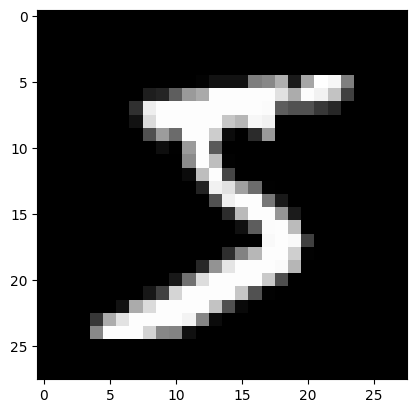

In [22]:
plt.imshow(dataset.data[0,:,:], cmap='gray', interpolation='none')

<class 'numpy.ndarray'>
input_vector : 
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  16  33   1
   0   0   0   0   0   0   0   0  55  93 111 116 126 105  89  28   0   0
   0   0   0   0 126 126 126 126 111 126 126 103   0   0   0   0   0   0
  68  50  19  15   0  22  61 124  22   0   0   0   0   0   0   0   0   0
   0   0  12 126  56   0   0   0   0   0   0   0   0   0   0   0  14 126
  35   0   0   0   0   0   0   0   0   0  37  85 121 126 114  77   0   0
   0   0   0   0   0  38 125 126 126 126 126 115   0   0   0   0   0   0
   3 102 126 126 121  45  22  11   0   0   0   0   0   0  18 126 126 125
  53   0   0   0   0   0   0   0   0   0   0  37  61   2   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
type: <class 'numpy.ndarray'>
mac: [     0      0   -623   2099   1374   3437   1548    199   3166  -9302
  16063 -34607   1084 -18561  -8643   2645  14450  -9550 

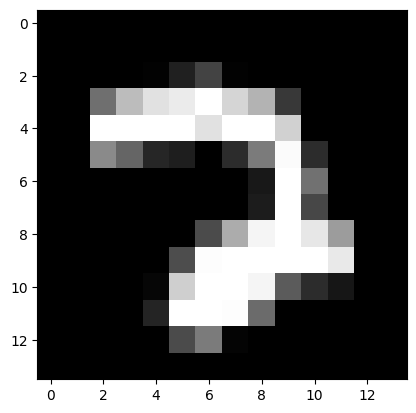

In [552]:
# Get one input image
input_image = (dataset.data[120,:,:].numpy().astype(float)*128/256).astype(np.int8)

# **Input Transformation**
# Step 1: Apply average pooling to the 28x28 matrix -> 14x14
pooled = average_pooling(input_image, pool_size=2)
plt.imshow(pooled, cmap='gray', interpolation='none')

# Step 2: Flatten the 14x14 matrix into a vector of size 196
input_feature = pooled.flatten().astype(np.int8)  # Flatten the matrix
print(type(input_feature))
print(f"input_vector : \n {input_feature}")

# **MLP Forward Pass**
# Layer 1: Hidden Layer
layer1_output = layer_forward(input_feature, weights_HL, biases_HL)
print(f"layer1_output : \n {layer1_output}")

# Layer 2: Output Layer
layer2_output = layer_forward(layer1_output, weights_OL, biases_OL)
print(f"layer2_output : \n {layer2_output}")

# Decision Block
predicted_digits = decision(layer2_output)
print(f'predicted digit: {predicted_digits}')